<a href="https://colab.research.google.com/github/WolfPitToad/SpriteGANPokemonGenerator/blob/Ejemplo_GAN/GAN_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras import Input

Ejemplo de Generador en Keras, en esta primera versión del modelo se proponia utilizar imagenes de resolución 96x96 sin embargo, posteriormente se reacalcularon las capas para procesar y generar imagenes de 64x64 debido al alto costo computacional que requeria esta configuración inicial

In [ ]:
def make_generator_model(num_examples,ruido,z_dim=3,x=1,y=1):
    model = tf.keras.Sequential()
    model.add(layers.Dense(256*12*12, use_bias=False, input_shape=(ruido,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((12, 12, 256)))
    assert model.output_shape == (None, 12, 12, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, z_dim)

    return model

In [ ]:
num_examples=2
ruido=128
generatorKeras=make_generator_model(num_examples,ruido)

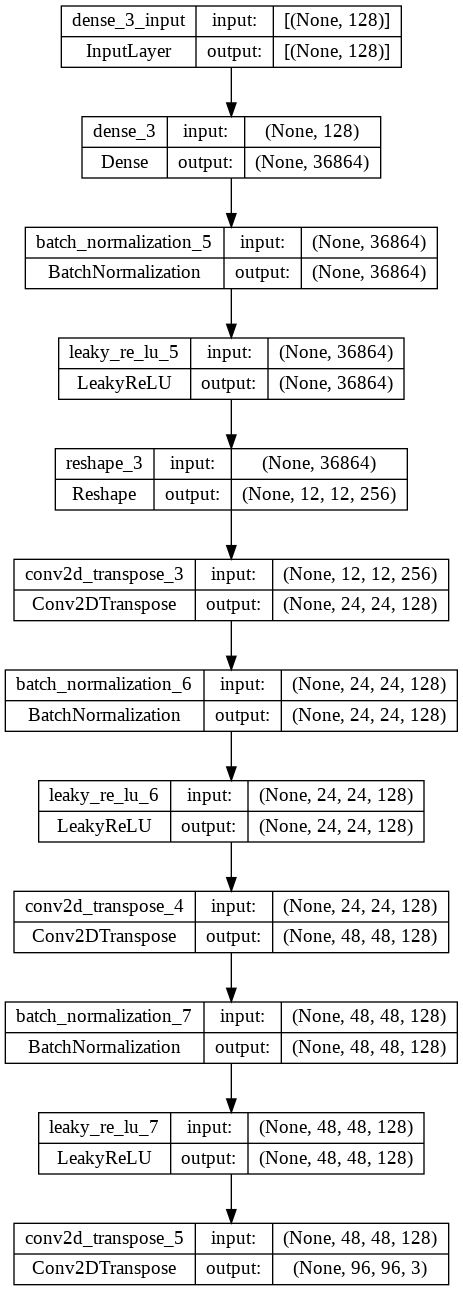

In [ ]:
Image(model_to_dot(generatorKeras, show_shapes=True).create_png())

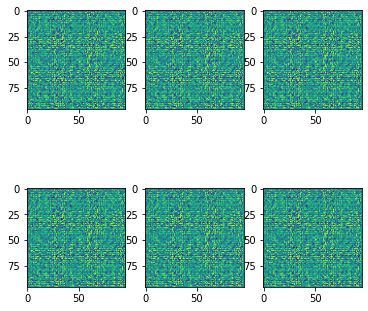

In [ ]:
#Ejemplo Generador
row=num_examples
col=3
seed=tf.random.normal([num_examples, ruido])
fake_image = generatorKeras(seed, training=True)
fig, axs = plt.subplots(row,col,figsize=(row * 3, col * 2))
for n in range(num_examples):
    for i in range(row):
            for j in range(col):
              axs[i][j].imshow(fake_image[n, :, :, 0])
              axs[i][j].imshow(fake_image[n, :, :, 1])
              axs[i][j].imshow(fake_image[n, :, :, 2])

In [ ]:
def make_discriminator_model(image_size,channels=3):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(256, (16, 16), strides=(2, 2), padding='same',
                                     input_shape=[image_size,image_size,channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (8, 8), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (6, 6), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (6, 6), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model(96)

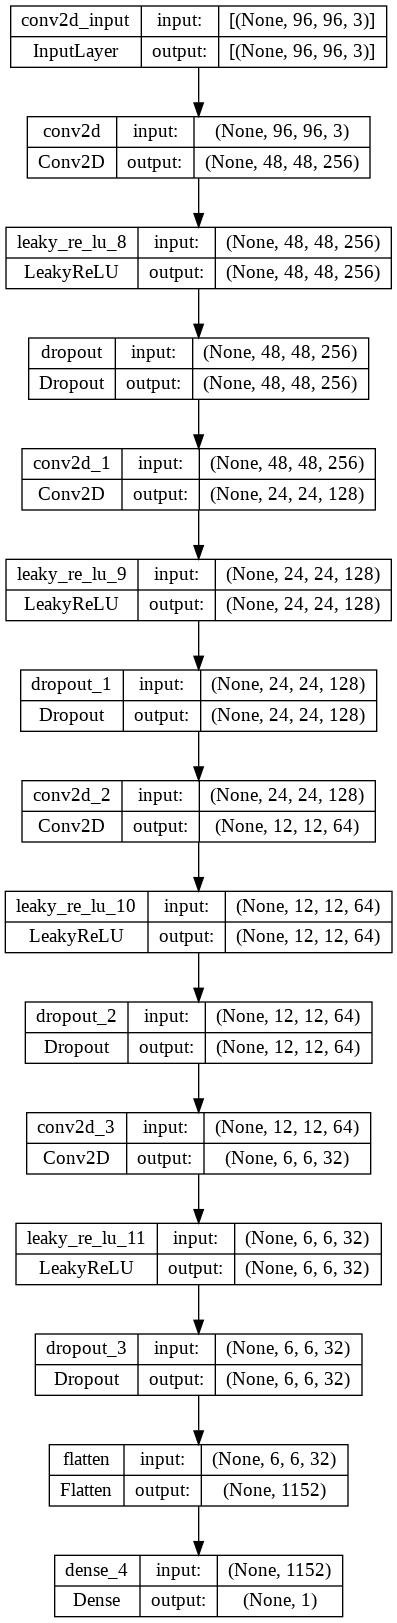

In [ ]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [ ]:
#Ejemplo de uso
decision = discriminator(fake_image)
print (decision)
print(discriminator.input_shape)

tf.Tensor(
[[-0.01077923]
 [ 0.01464827]], shape=(2, 1), dtype=float32)
(None, 96, 96, 3)


In [ ]:
#Estructura basica y simplificada de comunicación entre discriminador y generador en GAN
num_examples=2
ruido=128
epochs=3
for i in range(epochs):
  seed = tf.random.normal([num_examples, ruido])
  generator=make_generator_model(num_examples, ruido)
  fake_image = generator(seed, training=False)
  decision=discriminator(fake_image,  training=False)
  print(decision)

tf.Tensor(
[[-0.00021147]
 [ 0.00020175]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-2.707832e-05]
 [-4.905865e-04]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-0.00012379]
 [-0.00030408]], shape=(2, 1), dtype=float32)


Este proceso anterior se repite con las imagenes reales propias del dataset

In [ ]:
from numpy.ma.core import transpose
#Cambiamos el nombre por una columna con 1
labels=[1*(dataset.images.shape[0])]
labels=np.ones(labels)
labels=transpose(labels)
dataset.pkmn=labels

In [ ]:
#Reacondicionamos los datos

dataset.images=dataset.images.numpy()
dataset.images=dataset.images.swapaxes(1,2)
dataset.images=dataset.images.swapaxes(2,3)
#Reshape Dataset
print(dataset.images.shape)
print(dataset.pkmn.shape)